In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv("nyc_data.csv")
df = df.rename(columns={"Demand" : "y",
                        "Date" : "ds"})
df.head(5)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [40]:
# Date variable

df.ds = pd.to_datetime(df.ds, format='%m/%d/%Y')
df.ds.head()

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]

In [41]:
# Holidays
# Easter

dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({"holiday": "easter",
                       "ds" : dates,
                       "lower_window" : -5,
                       "upper_window" : 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [42]:
# Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({"holiday": "thanksgiving",
                       "ds" : dates,
                       "lower_window" : -3,
                       "upper_window" : 5})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,5
693,thanksgiving,2016-11-24,-3,5
1057,thanksgiving,2017-11-23,-3,5
1421,thanksgiving,2018-11-22,-3,5
1792,thanksgiving,2019-11-28,-3,5
2156,thanksgiving,2020-11-26,-3,5


In [43]:
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,5
693,thanksgiving,2016-11-24,-3,5
1057,thanksgiving,2017-11-23,-3,5
1421,thanksgiving,2018-11-22,-3,5


In [7]:
df = df.drop(columns=["Easter", "Thanksgiving"])

# PROPHET MODEL

In [44]:
from prophet import Prophet

In [9]:
model = Prophet(holidays=holidays,
                seasonality_mode = "multiplicative",
                seasonality_prior_scale = 10,
                holidays_prior_scale = 10,
                changepoint_prior_scale = 0.5)

model.add_regressor("Christmas")
model.add_regressor("Temperature")
model.add_regressor("Marketing")

model.fit(df)


20:50:49 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing


## Cross-validation

In [4]:
from prophet.diagnostics import cross_validation

In [11]:
df_cv = cross_validation(model,
                         horizon = "31 days",
                         period = "16 days",
                         initial = "2012 days", #df.shape[0] - 180 (6 months)
                         parallel = "processes")

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,616.919246,554.918953,677.813727,571.069531,2020-07-09
1,2020-07-11,735.492966,667.578097,797.887893,677.106981,2020-07-09
2,2020-07-12,649.586229,583.303556,709.537414,619.572774,2020-07-09
3,2020-07-13,784.349204,724.175807,848.637742,808.932621,2020-07-09
4,2020-07-14,649.748544,582.344867,705.218277,661.791644,2020-07-09


In [5]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [13]:
# Performance

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2771.214494,52.642326,45.045724,0.063733,0.048442,0.062860,0.832258
1,5 days,3061.927352,55.334685,47.083367,0.067434,0.059769,0.066019,0.741935
2,6 days,3328.783735,57.695613,50.292930,0.070984,0.068063,0.070094,0.700000
3,7 days,2723.982743,52.191788,44.108951,0.063278,0.057707,0.062226,0.767742
4,8 days,2221.065426,47.128181,38.408562,0.053932,0.033162,0.053690,0.796774
5,9 days,1186.296029,34.442648,28.740584,0.039412,0.033126,0.039631,0.922581
6,10 days,1281.310627,35.795400,29.325195,0.040695,0.032196,0.040806,0.903226
7,11 days,1290.961479,35.929952,30.112829,0.042741,0.035380,0.042552,0.929032
8,12 days,2178.385467,46.673177,38.356448,0.055214,0.040870,0.054661,0.741935
9,13 days,2557.093747,50.567714,43.127159,0.061859,0.058046,0.061426,0.674194


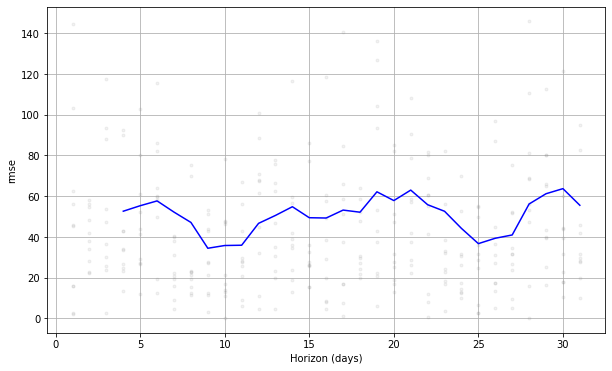

In [14]:
plot_cross_validation_metric(df_cv, metric = "rmse");

# Parameter Tuning

In [15]:
from sklearn.model_selection import ParameterGrid

c:\Users\ultra\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
param_grid = {"seasonality_mode" :["additive", "multiplicative"],
                "seasonality_prior_scale" : [1, 5, 10, 20],
                "holidays_prior_scale" : [5, 10, 20, 25],
                "changepoint_prior_scale" : [0.005, 0.01, 0.05, 0.1]
}

grid = ParameterGrid(param_grid)


In [17]:
list(grid)

[{'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_s

In [18]:
len(list(grid))

128

In [19]:
rmse = []

for i, params in enumerate(grid, start = 1):

    print(f"Running {i} / {len(list(grid))}")
    
    #Model
    model = Prophet(holidays=holidays,
                    seasonality_mode = params["seasonality_mode"],
                    seasonality_prior_scale = params["seasonality_prior_scale"],
                    holidays_prior_scale = params["holidays_prior_scale"],
                    changepoint_prior_scale = params["changepoint_prior_scale"])
    model.add_regressor("Christmas")
    model.add_regressor("Temperature")
    model.add_regressor("Marketing")

    model.fit(df)

    #CV
    df_cv = cross_validation(model,
                         horizon = "31 days",
                         period = "16 days",
                         initial = "2012 days", #df.shape[0] - 180 (6 months)
                         parallel = "processes")

    epoch_rmse = performance_metrics(df_cv)["rmse"].mean()
    print(f"RMSE for epoch {i} is {epoch_rmse}")
    #Measure Error and Store
    rmse.append(epoch_rmse)

Running 1 / 128


20:51:34 - cmdstanpy - INFO - Chain [1] start processing
20:51:34 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 1 is 53.18518315760396
Running 2 / 128


20:51:52 - cmdstanpy - INFO - Chain [1] start processing
20:51:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 2 is 52.879007813534066
Running 3 / 128


20:52:09 - cmdstanpy - INFO - Chain [1] start processing
20:52:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 3 is 53.31542253028949
Running 4 / 128


20:52:26 - cmdstanpy - INFO - Chain [1] start processing
20:52:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 4 is 52.9833463921711
Running 5 / 128


20:52:42 - cmdstanpy - INFO - Chain [1] start processing
20:52:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 5 is 49.77267660508992
Running 6 / 128


20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 6 is 49.91301895539415
Running 7 / 128


20:53:23 - cmdstanpy - INFO - Chain [1] start processing
20:53:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 7 is 50.38133985730108
Running 8 / 128


20:53:41 - cmdstanpy - INFO - Chain [1] start processing
20:53:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 8 is 50.799200263690636
Running 9 / 128


20:54:00 - cmdstanpy - INFO - Chain [1] start processing
20:54:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 9 is 53.54058942121667
Running 10 / 128


20:54:20 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 10 is 52.694675220806644
Running 11 / 128


20:54:38 - cmdstanpy - INFO - Chain [1] start processing
20:54:38 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 11 is 52.233644940707464
Running 12 / 128


20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 12 is 52.650079024605354
Running 13 / 128


20:55:17 - cmdstanpy - INFO - Chain [1] start processing
20:55:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 13 is 49.9654027066743
Running 14 / 128


20:55:35 - cmdstanpy - INFO - Chain [1] start processing
20:55:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 14 is 49.920043676916286
Running 15 / 128


20:55:51 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 15 is 50.24911154301185
Running 16 / 128


20:56:07 - cmdstanpy - INFO - Chain [1] start processing
20:56:07 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 16 is 50.305127348426346
Running 17 / 128


20:56:22 - cmdstanpy - INFO - Chain [1] start processing
20:56:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 17 is 53.23893515483019
Running 18 / 128


20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 18 is 52.70570563252104
Running 19 / 128


20:56:53 - cmdstanpy - INFO - Chain [1] start processing
20:56:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 19 is 52.424861099941374
Running 20 / 128


20:57:09 - cmdstanpy - INFO - Chain [1] start processing
20:57:10 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 20 is 52.75270968254707
Running 21 / 128


20:57:25 - cmdstanpy - INFO - Chain [1] start processing
20:57:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 21 is 50.15330334991899
Running 22 / 128


20:57:40 - cmdstanpy - INFO - Chain [1] start processing
20:57:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 22 is 50.1731920313859
Running 23 / 128


20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 23 is 49.68611276953048
Running 24 / 128


20:58:08 - cmdstanpy - INFO - Chain [1] start processing
20:58:08 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 24 is 50.230943588390446
Running 25 / 128


20:58:24 - cmdstanpy - INFO - Chain [1] start processing
20:58:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 25 is 52.846428024809335
Running 26 / 128


20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 26 is 53.17062693926693
Running 27 / 128


20:58:55 - cmdstanpy - INFO - Chain [1] start processing
20:58:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 27 is 52.81652791937654
Running 28 / 128


20:59:11 - cmdstanpy - INFO - Chain [1] start processing
20:59:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 28 is 53.20561614268297
Running 29 / 128


20:59:25 - cmdstanpy - INFO - Chain [1] start processing
20:59:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 29 is 51.016449405476386
Running 30 / 128


20:59:41 - cmdstanpy - INFO - Chain [1] start processing
20:59:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 30 is 50.1586540156972
Running 31 / 128


20:59:57 - cmdstanpy - INFO - Chain [1] start processing
20:59:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 31 is 50.04510147839981
Running 32 / 128


21:00:11 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 32 is 49.81218706781815
Running 33 / 128


21:00:25 - cmdstanpy - INFO - Chain [1] start processing
21:00:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 33 is 48.36698747299489
Running 34 / 128


21:00:41 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 34 is 47.87161449453226
Running 35 / 128


21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 35 is 48.87176184925083
Running 36 / 128


21:01:11 - cmdstanpy - INFO - Chain [1] start processing
21:01:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 36 is 48.42749722289296
Running 37 / 128


21:01:26 - cmdstanpy - INFO - Chain [1] start processing
21:01:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 37 is 49.03229493075894
Running 38 / 128


21:01:40 - cmdstanpy - INFO - Chain [1] start processing
21:01:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 38 is 49.222530815046824
Running 39 / 128


21:01:55 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 39 is 49.229139496468584
Running 40 / 128


21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 40 is 49.128357706886604
Running 41 / 128


21:02:27 - cmdstanpy - INFO - Chain [1] start processing
21:02:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 41 is 48.351337305396044
Running 42 / 128


21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 42 is 48.20016382117325
Running 43 / 128


21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:03:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 43 is 48.31966540390166
Running 44 / 128


21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 44 is 48.25625968570298
Running 45 / 128


21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 45 is 49.24545103790732
Running 46 / 128


21:03:49 - cmdstanpy - INFO - Chain [1] start processing
21:03:49 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 46 is 49.105057322621064
Running 47 / 128


21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 47 is 49.22858642453087
Running 48 / 128


21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 48 is 49.284183018956604
Running 49 / 128


21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 49 is 48.588767810697156
Running 50 / 128


21:04:53 - cmdstanpy - INFO - Chain [1] start processing
21:04:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 50 is 48.267641799741774
Running 51 / 128


21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 51 is 48.37758131383588
Running 52 / 128


21:05:26 - cmdstanpy - INFO - Chain [1] start processing
21:05:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 52 is 48.419223503170016
Running 53 / 128


21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 53 is 49.16691452339314
Running 54 / 128


21:05:55 - cmdstanpy - INFO - Chain [1] start processing
21:05:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 54 is 49.183127509550175
Running 55 / 128


21:06:11 - cmdstanpy - INFO - Chain [1] start processing
21:06:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 55 is 49.08250436215544
Running 56 / 128


21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 56 is 48.86422845389096
Running 57 / 128


21:06:43 - cmdstanpy - INFO - Chain [1] start processing
21:06:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 57 is 48.362882409169615
Running 58 / 128


21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 58 is 48.37545157307342
Running 59 / 128


21:07:12 - cmdstanpy - INFO - Chain [1] start processing
21:07:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 59 is 48.276362326213466
Running 60 / 128


21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 60 is 48.829043757161976
Running 61 / 128


21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 61 is 49.03962582046755
Running 62 / 128


21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 62 is 49.4215569636979
Running 63 / 128


21:08:12 - cmdstanpy - INFO - Chain [1] start processing
21:08:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 63 is 49.55030373406989
Running 64 / 128


21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 64 is 49.168146255874426
Running 65 / 128


21:08:42 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 65 is 49.910960283182796
Running 66 / 128


21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 66 is 49.901114739164846
Running 67 / 128


21:09:21 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 67 is 50.07432964488339
Running 68 / 128


21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 68 is 50.029867365661666
Running 69 / 128


21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 69 is 53.661950632390884
Running 70 / 128


21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 70 is 53.73929694580984
Running 71 / 128


21:10:38 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 71 is 53.717080249352314
Running 72 / 128


21:10:58 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 72 is 53.78734444751383
Running 73 / 128


21:11:18 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 73 is 49.93084964419454
Running 74 / 128


21:11:38 - cmdstanpy - INFO - Chain [1] start processing
21:11:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 74 is 50.0910102987554
Running 75 / 128


21:11:58 - cmdstanpy - INFO - Chain [1] start processing
21:11:59 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 75 is 50.17482778683199
Running 76 / 128


21:12:19 - cmdstanpy - INFO - Chain [1] start processing
21:12:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 76 is 49.9556025872118
Running 77 / 128


21:12:39 - cmdstanpy - INFO - Chain [1] start processing
21:12:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 77 is 54.01962330006175
Running 78 / 128


21:13:01 - cmdstanpy - INFO - Chain [1] start processing
21:13:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 78 is 53.75749881013736
Running 79 / 128


21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 79 is 53.87900814021837
Running 80 / 128


21:13:39 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 80 is 53.79821543412101
Running 81 / 128


21:13:57 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 81 is 49.80674045174063
Running 82 / 128


21:14:17 - cmdstanpy - INFO - Chain [1] start processing
21:14:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 82 is 50.04920528211538
Running 83 / 128


21:14:38 - cmdstanpy - INFO - Chain [1] start processing
21:14:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 83 is 49.76867957958241
Running 84 / 128


21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 84 is 50.079884433261256
Running 85 / 128


21:15:19 - cmdstanpy - INFO - Chain [1] start processing
21:15:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 85 is 53.860167030284565
Running 86 / 128


21:15:38 - cmdstanpy - INFO - Chain [1] start processing
21:15:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 86 is 53.5857485600058
Running 87 / 128


21:15:57 - cmdstanpy - INFO - Chain [1] start processing
21:15:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 87 is 53.807023424886246
Running 88 / 128


21:16:19 - cmdstanpy - INFO - Chain [1] start processing
21:16:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 88 is 53.7787023802389
Running 89 / 128


21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 89 is 49.94009698032663
Running 90 / 128


21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 90 is 49.82479714375291
Running 91 / 128


21:17:20 - cmdstanpy - INFO - Chain [1] start processing
21:17:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 91 is 49.94444613273659
Running 92 / 128


21:17:40 - cmdstanpy - INFO - Chain [1] start processing
21:17:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 92 is 50.05597524165752
Running 93 / 128


21:17:59 - cmdstanpy - INFO - Chain [1] start processing
21:18:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 93 is 53.57946754154754
Running 94 / 128


21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 94 is 53.73784023084828
Running 95 / 128


21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 95 is 53.88097979702235
Running 96 / 128


21:18:56 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 96 is 53.96507635977413
Running 97 / 128


21:19:17 - cmdstanpy - INFO - Chain [1] start processing
21:19:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 97 is 49.54069048255393
Running 98 / 128


21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 98 is 49.37956771565091
Running 99 / 128


21:20:05 - cmdstanpy - INFO - Chain [1] start processing
21:20:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 99 is 49.499470771181734
Running 100 / 128


21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:30 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 100 is 49.49011447262729
Running 101 / 128


21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 101 is 53.32297680896327
Running 102 / 128


21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 102 is 53.52182483429453
Running 103 / 128


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 103 is 53.37527955532264
Running 104 / 128


21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 104 is 53.36085179995141
Running 105 / 128


21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 105 is 49.54767181031839
Running 106 / 128


21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 106 is 49.41446818331339
Running 107 / 128


21:23:16 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 107 is 49.54745272861315
Running 108 / 128


21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 108 is 49.55403835457431
Running 109 / 128


21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 109 is 53.47789516624173
Running 110 / 128


21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 110 is 53.27885114347597
Running 111 / 128


21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 111 is 53.295144383926605
Running 112 / 128


21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 112 is 53.57553945140023
Running 113 / 128


21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 113 is 49.62102098224799
Running 114 / 128


21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 114 is 49.57136846780582
Running 115 / 128


21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 115 is 49.51931040013687
Running 116 / 128


21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 116 is 49.42042216491779
Running 117 / 128


21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 117 is 53.45396878984945
Running 118 / 128


21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 118 is 53.44036687908761
Running 119 / 128


21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 119 is 53.23066539744531
Running 120 / 128


21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 120 is 53.40875118169456
Running 121 / 128


21:28:49 - cmdstanpy - INFO - Chain [1] start processing
21:28:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 121 is 49.5638683245561
Running 122 / 128


21:29:14 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 122 is 49.545245924347135
Running 123 / 128


21:29:39 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 123 is 49.52362007540417
Running 124 / 128


21:30:02 - cmdstanpy - INFO - Chain [1] start processing
21:30:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 124 is 49.492092296323996
Running 125 / 128


21:30:29 - cmdstanpy - INFO - Chain [1] start processing
21:30:30 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 125 is 53.38118056541458
Running 126 / 128


21:30:53 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 126 is 53.501925958486844
Running 127 / 128


21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 127 is 53.15809010335134
Running 128 / 128


21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 128 is 53.46222339077253


In [21]:
results = pd.DataFrame(grid)
results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale
0,0.005,5,additive,1
1,0.005,5,additive,5
2,0.005,5,additive,10
3,0.005,5,additive,20
4,0.005,5,multiplicative,1
...,...,...,...,...
123,0.100,25,additive,20
124,0.100,25,multiplicative,1
125,0.100,25,multiplicative,5
126,0.100,25,multiplicative,10


In [29]:
results["rmse"] = rmse
results.sort_values(by = "rmse", ascending = True, inplace=True)
results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
31,0.005,25,multiplicative,20,47.871614
33,0.010,5,additive,5,48.200164
70,0.050,5,multiplicative,10,48.256260
93,0.050,25,multiplicative,5,48.267642
127,0.100,25,multiplicative,20,48.276362
...,...,...,...,...,...
25,0.005,25,additive,5,53.860167
29,0.005,25,multiplicative,5,53.879008
4,0.005,5,multiplicative,1,53.880980
27,0.005,25,additive,20,53.965076


In [46]:
best_results = results.loc[0, :].to_frame().transpose()
best_results.to_csv("best_results.csv", index=False)

In [47]:
best_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,49.550304


In [45]:
future_df = pd.read_csv("future.csv")
future_df = future_df.rename(columns={"Demand" : "y",
                        "Date" : "ds"})
future_df.ds = pd.to_datetime(future_df.ds, format='%m/%d/%Y')
future_df.head(10)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2021-01-01,NaN,0,0,0,5.00,154.221
1,2021-01-02,NaN,0,0,0,11.11,264.805
2,2021-01-03,NaN,0,0,0,3.89,115.499
3,2021-01-04,NaN,0,0,0,6.67,124.650
4,2021-01-05,NaN,0,0,0,5.56,77.968
5,2021-01-06,NaN,0,0,0,5.56,234.200
6,2021-01-07,NaN,0,0,0,6.11,142.041
7,2021-01-08,NaN,0,0,0,3.89,252.094
8,2021-01-09,NaN,0,0,0,2.78,100.483
9,2021-01-10,NaN,0,0,0,6.11,71.600


In [46]:
df_concat = pd.concat([df, future_df]).reset_index(drop=True)
df_concat

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2218,2021-01-27,NaN,0,0,0,3.33,39.664
2219,2021-01-28,NaN,0,0,0,1.67,195.314
2220,2021-01-29,NaN,0,0,0,-2.78,235.894
2221,2021-01-30,NaN,0,0,0,1.11,152.752


In [47]:
dates = pd.to_datetime(df_concat[df_concat.Easter == 1].ds)
easter = pd.DataFrame({"holiday": "easter",
                       "ds" : dates,
                       "lower_window" : -5,
                       "upper_window" : 2})

dates = pd.to_datetime(df_concat[df_concat.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({"holiday": "thanksgiving",
                       "ds" : dates,
                       "lower_window" : -3,
                       "upper_window" : 5})


holidays = pd.concat([easter, thanksgiving])

df_concat = df_concat.drop(columns=["Easter", "Thanksgiving"])

In [48]:
#Split data

training_data = df_concat.iloc[: -31, :]
future_data = df_concat.iloc[-31 :, :]

In [49]:
training_data.tail()

,ds,y,Christmas,Temperature,Marketing
2187,2020-12-27,685.915026,0,2.89,38.674
2188,2020-12-28,998.051170,0,8.83,166.712
2189,2020-12-29,847.123399,0,3.48,161.865
2190,2020-12-30,857.521043,0,5.97,179.634
2191,2020-12-31,783.891494,0,8.22,149.221


In [13]:
params = pd.read_csv("best_results.csv")
params

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,49.550304


In [50]:
model = Prophet(holidays=holidays,
                    seasonality_mode = params["seasonality_mode"][0],
                    seasonality_prior_scale = params["seasonality_prior_scale"][0],
                    holidays_prior_scale = params["holidays_prior_scale"][0],
                    changepoint_prior_scale = params["changepoint_prior_scale"][0])
model.add_regressor("Christmas")
model.add_regressor("Temperature")
model.add_regressor("Marketing")

model.fit(training_data)

19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:43 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

In [51]:
future = model.make_future_dataframe(periods = len(future_data),
                            freq = "D")

future = pd.concat([future, df_concat.iloc[:, 2: ]], axis=1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [52]:
forecast = model.predict(future)
forecast.tail(31)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2192,2021-01-01,725.368783,665.826765,801.190847,725.368783,725.368783,0.0,0.0,0.0,1.427560,...,-89.416913,-89.416913,-89.416913,87.486117,87.486117,87.486117,0.0,0.0,0.0,735.953619
2193,2021-01-02,724.989377,782.038636,917.408665,724.989377,724.989377,0.0,0.0,0.0,7.158714,...,25.147626,25.147626,25.147626,86.445796,86.445796,86.445796,0.0,0.0,0.0,848.063336
2194,2021-01-03,724.609972,690.922847,838.934188,724.609972,724.609972,0.0,0.0,0.0,-0.579256,...,-55.725333,-55.725333,-55.725333,85.573947,85.573947,85.573947,0.0,0.0,0.0,766.196622
2195,2021-01-04,724.230566,820.096956,957.408486,724.230566,724.230566,0.0,0.0,0.0,-0.104994,...,74.205261,74.205261,74.205261,84.882905,84.882905,84.882905,0.0,0.0,0.0,892.452441
2196,2021-01-05,723.851161,692.256295,831.285313,723.851161,723.851161,0.0,0.0,0.0,-2.524347,...,-53.804184,-53.804184,-53.804184,84.379658,84.379658,84.379658,0.0,0.0,0.0,762.370212
2197,2021-01-06,723.471755,855.740798,993.669480,723.471755,723.471755,0.0,0.0,0.0,5.572572,...,103.661393,103.661393,103.661393,84.065772,84.065772,84.065772,0.0,0.0,0.0,927.239417
2198,2021-01-07,723.092350,742.840912,886.570496,723.092350,723.092350,0.0,0.0,0.0,0.796316,...,-4.067850,-4.067850,-4.067850,83.937445,83.937445,83.937445,0.0,0.0,0.0,813.617112
2199,2021-01-08,722.712944,665.909305,800.375777,722.712944,722.712944,0.0,0.0,0.0,6.499950,...,-89.416913,-89.416913,-89.416913,83.985702,83.985702,83.985702,0.0,0.0,0.0,736.098976
2200,2021-01-09,722.333539,770.412702,912.590186,722.333539,722.333539,0.0,0.0,0.0,-1.357479,...,25.147626,25.147626,25.147626,84.196712,84.196712,84.196712,0.0,0.0,0.0,843.866910
2201,2021-01-10,721.954133,690.678529,828.941002,721.954133,721.954133,0.0,0.0,0.0,-2.854377,...,-55.725333,-55.725333,-55.725333,84.552225,84.552225,84.552225,0.0,0.0,0.0,757.785501


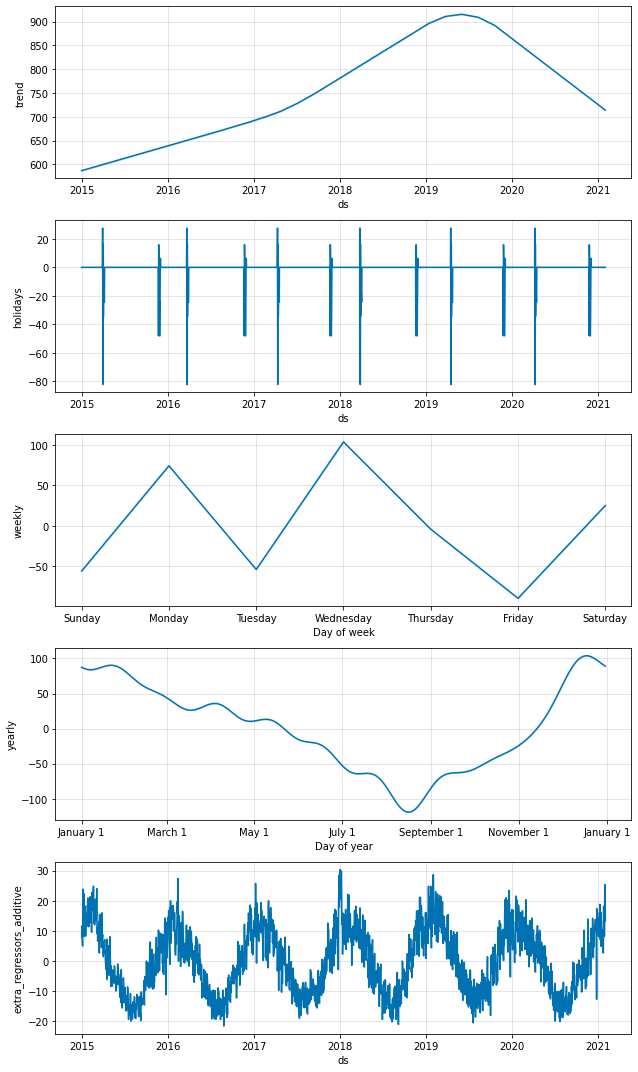

In [53]:
model.plot_components(forecast);

In [54]:
predictions = forecast.yhat[-31:].rename("predictions")
predictions.index = future_data["ds"]
predictions

ds
2021-01-01    735.953619
2021-01-02    848.063336
2021-01-03    766.196622
2021-01-04    892.452441
2021-01-05    762.370212
2021-01-06    927.239417
2021-01-07    813.617112
2021-01-08    736.098976
2021-01-09    843.866910
2021-01-10    757.785501
2021-01-11    893.509929
2021-01-12    769.248047
2021-01-13    915.609715
2021-01-14    817.209384
2021-01-15    725.719694
2021-01-16    842.176000
2021-01-17    762.878273
2021-01-18    892.916672
2021-01-19    760.883753
2021-01-20    917.914506
2021-01-21    814.121920
2021-01-22    721.038573
2021-01-23    843.181916
2021-01-24    768.820798
2021-01-25    887.679024
2021-01-26    766.887781
2021-01-27    915.038669
2021-01-28    815.714719
2021-01-29    735.737512
2021-01-30    839.883623
2021-01-31    753.702671
Name: predictions, dtype: float64

In [56]:
predictions.to_csv("prophet_predictions.csv")